**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
#from sklearn.datasets import fetch_mldata, fetch_20newsgroups
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
from sklearn.model_selection import KFold
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KDTree
from scipy import sparse
from sklearn.metrics import pairwise_distances

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [3]:
class MyKNeighborsClassifier(BaseEstimator):

    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.neighbors = n_neighbors
        self.algs = algorithm
        self.metric = metric
    
    def fit(self, X, y):
        X = X.astype(float)
        if type(X) == sparse.csr.csr_matrix:
            self.y = y
            self.X = X          
        else:    
            self.X = np.array(X).astype(float)
            self.y = np.array(y)
            if(self.algs == 'kd_tree'):
                self.tree = KDTree(X, leaf_size = 10)
        self.numbofclasses = np.shape(np.unique(self.y))[0]
    
    def predict(self, X):
        X = X.astype(float)
        if type(X) == sparse.csr.csr_matrix:
            if(self.algs == 'brute'):
                if self.metric == 'cosine':
                    index = pairwise_distances(X=X, Y=self.X, metric = 'cosine').argsort(axis = 1)[:,:self.neighbors]
                if self.metric == 'euclidean':
                    index = pairwise_distances(X=X, Y=self.X ).argsort(axis = 1)[:,:self.neighbors]
        else:
            if(self.algs == 'kd_tree'):
                index = self.tree.query(X, k = self.neighbors, return_distance = False)
            if(self.algs == 'brute'):
                index = cdist(X, self.X, self.metric).argsort(axis = 1)[:,:self.neighbors]

        prediction = np.zeros( (X.shape[0], self.numbofclasses), dtype = int )
        for i in range (index.shape[0]):
            for j in index[i]:
                prediction[i][int(self.y[j])] += 1
        prediction = np.argmax(prediction, axis=1)
        return prediction

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [56]:
%time clf.fit(X_train, y_train)

Wall time: 1.49 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [58]:
%time my_clf.fit(X_train, y_train)

Wall time: 747 µs


In [44]:
%time clf.predict(X_test)

Wall time: 2.24 ms


array([0, 2, 0, 1, 1, 0, 2, 2, 2, 1, 0, 2, 0, 2, 1])

In [45]:
%time my_clf.predict(X_test)

Wall time: 761 µs


array([0, 2, 0, 1, 1, 0, 2, 2, 2, 1, 0, 2, 0, 2, 1], dtype=int64)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [59]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [60]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [61]:
%time clf.fit(X_train, y_train)

Wall time: 3.71 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [62]:
%time my_clf.fit(X_train, y_train)

Wall time: 721 µs


In [63]:
%time clf.predict(X_test)

Wall time: 2.24 ms


array([1, 2, 1, 2, 0, 1, 2, 2, 0, 2, 0, 2, 0, 0, 1])

In [65]:
%time my_clf.predict(X_test)

Wall time: 746 µs


array([1, 2, 1, 2, 0, 1, 2, 2, 0, 2, 0, 2, 0, 0, 1], dtype=int64)

In [66]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [67]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [68]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [69]:
FuncVectorizer = CountVectorizer(min_df=0.02, max_df=0.15, stop_words='english')
FuncVectorizer.fit(data)
X_data = FuncVectorizer.transform(data)
y_data = target

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [70]:
result = []
k = 2
Knn = MyKNeighborsClassifier(n_neighbors = k, algorithm='brute', metric = 'euclidean')
Folds = KFold(n_splits = 3)
for train_id , test_id in Folds.split(X_data):
    X_train = X_data[train_id]
    X_test  = X_data[test_id]
    y_train = y_data[train_id]
    y_test = y_data[test_id]
    Knn.fit(X_train, y_train)
    Prediction = Knn.predict(X_test)
    score = accuracy_score(y_test, Prediction)
    result.append(score)

In [71]:
result

[0.19485683987274655, 0.1864226995491912, 0.2052505966587112]

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [72]:
def TheBest_N(X, y , metric = 'euclidean'):
    finalscore = []
    
    for N in range(1,11):
        if (metric == 'cosine'):
            Knn = MyKNeighborsClassifier(n_neighbors = N, algorithm = 'brute',metric = 'cosine')
        else:
            Knn = MyKNeighborsClassifier  (n_neighbors = N, algorithm = 'brute',metric = 'euclidean')
        Folds = KFold(n_splits=3)
        for train_id, test_id in Folds.split(X):
            scoreres = []
            X_train = X_data[train_id]
            X_test  = X_data[test_id]
            y_train = y_data[train_id]
            y_test = y_data[test_id]
            Knn.fit(X_train, y_train)
            Prediction = Knn.predict(X_test)
            curscore = accuracy_score(y_test, Prediction)
            scoreres.append(curscore)
        scoreres = np.asarray(scoreres)
        finalscore.append( scoreres.mean() )
    finalscore = np.asarray(finalscore)
    return finalscore

In [73]:
score = TheBest_N(X_data,y_data, metric = 'euclidean')

Best number of neighbours: 6


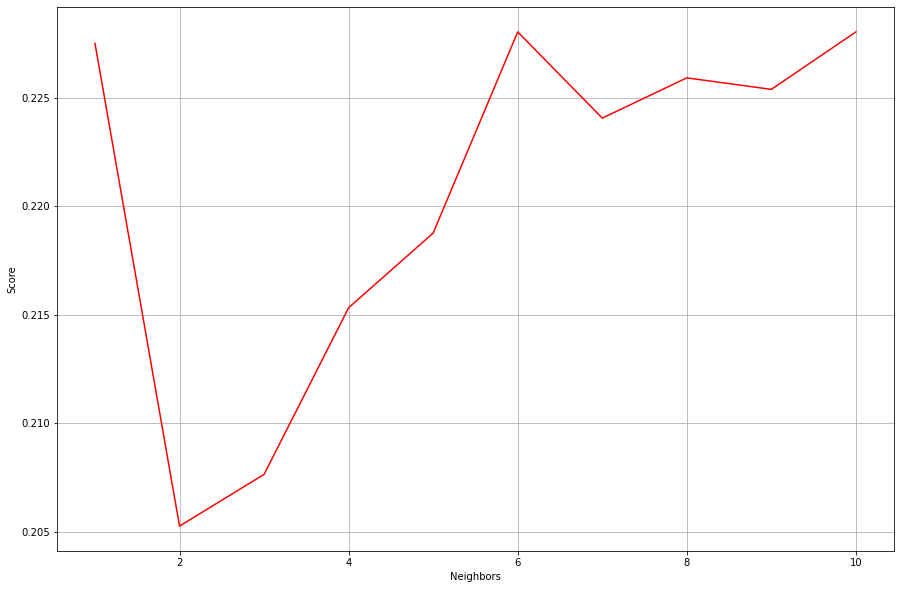

In [74]:
best = np.argmax(score) + 1
print("Best number of neighbours:", best)

plt.figure(figsize=(15,10))
plt.plot(list(range(1, 11)), score, color='red')
plt.xlabel('Neighbors')
plt.ylabel('Score')
plt.grid()
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [75]:
score1 = TheBest_N(X_data,y_data, metric = 'euclidean')
score2 = TheBest_N(X_data,y_data, metric = 'cosine')

In [76]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.02, max_df=0.15, stop_words='english')
tfidf_vectorizer.fit(data)
X_data = tfidf_vectorizer.transform(data)
y_data = target

In [77]:
score3 = TheBest_N(X_data,y_data, metric = 'euclidean')
score4 = TheBest_N(X_data,y_data, metric = 'cosine')

Best number of neighbours: 6


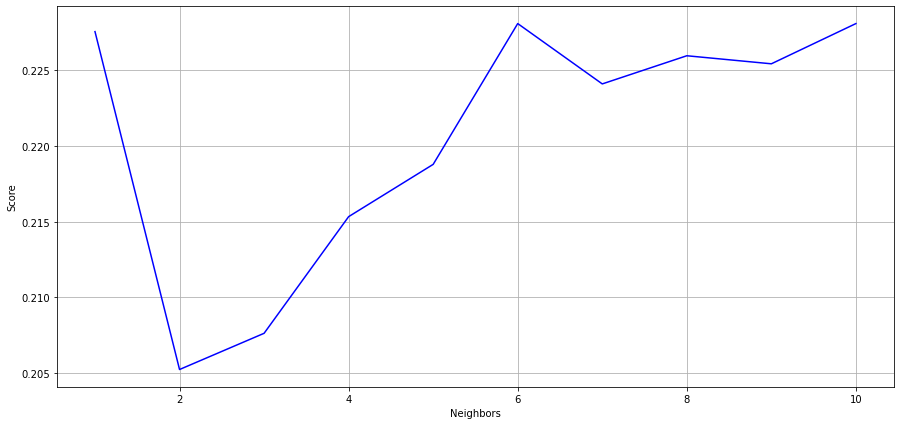

In [78]:
best1 = np.argmax(score1)
print("Best number of neighbours:", best1 + 1)

plt.figure(figsize=(15,7))
plt.plot(list(range(1, 11)), score1, color='blue')
plt.xlabel('Neighbors')
plt.ylabel('Score')
plt.grid()
plt.show()

Best number of neighbours: 10


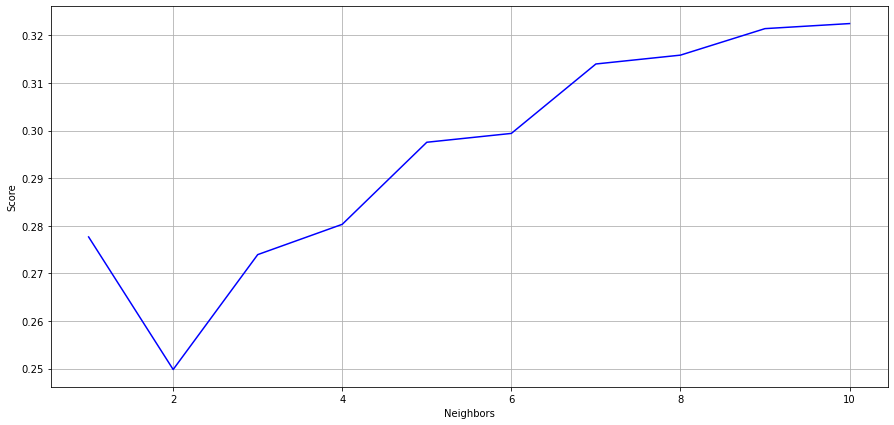

In [89]:
best2 = np.argmax(score2)
print("Best number of neighbours:", best2 + 1)

plt.figure(figsize=(15,7))
plt.plot(list(range(1, 11)), score2, color='blue')
plt.xlabel('Neighbors')
plt.ylabel('Score')
plt.grid()
plt.show()

Best number of neighbours: 1


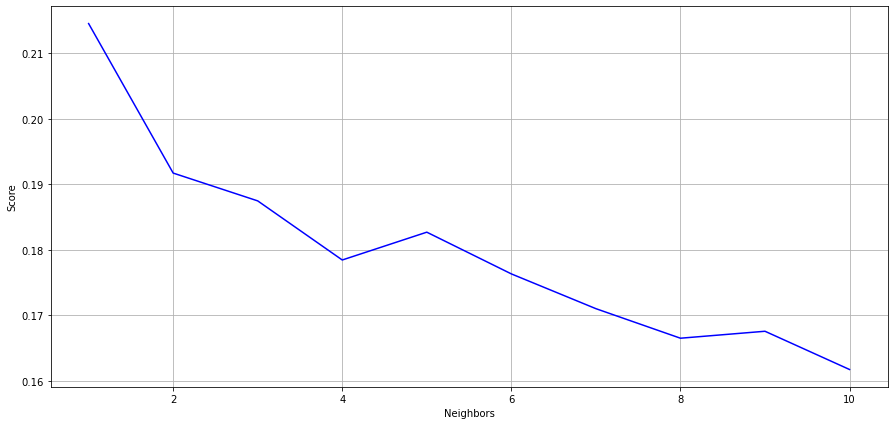

In [90]:
best3 = np.argmax(score3)
print("Best number of neighbours:", best3 + 1)

plt.figure(figsize=(15,7))
plt.plot(list(range(1, 11)), score3, color='blue')
plt.xlabel('Neighbors')
plt.ylabel('Score')
plt.grid()
plt.show()

Best number of neighbours: 10


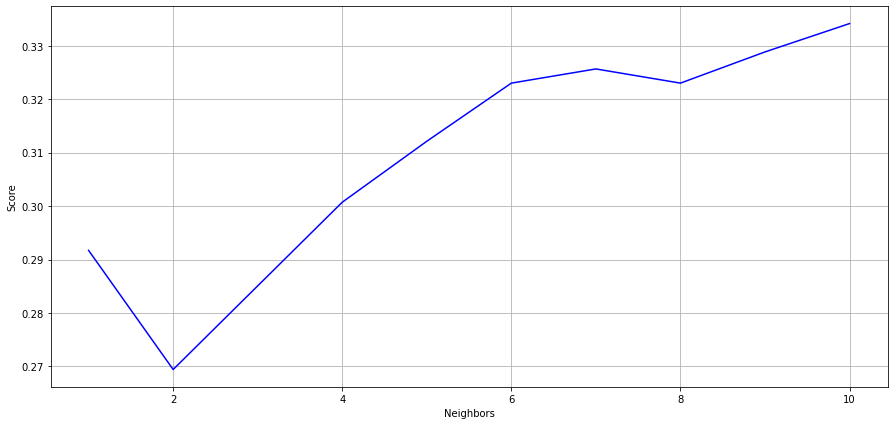

In [81]:
best4 = np.argmax(score4)
print("Best number of neighbours:", best4 + 1)

plt.figure(figsize=(15,7))
plt.plot(list(range(1, 11)), score4, color='blue')
plt.xlabel('Neighbors')
plt.ylabel('Score')
plt.grid()
plt.show()

In [91]:
scores = []
scores.append(score1[best1])
scores.append(score2[best2])
scores.append(score3[best3])
scores.append(score4[best4])
scores

[0.22805621850967914,
 0.3224608857067091,
 0.2145319543887563,
 0.3341288782816229]

In [83]:
#Выходит, наилучшая модель вышла в случае, когда я брал TfidfVectorizer и косинусную метрику

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [84]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [85]:
test_data = newsgroups['data']
test_target = newsgroups['target']

In [86]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.02, max_df=0.15, stop_words='english')
tfidf_vectorizer.fit(test_data)
X_data = tfidf_vectorizer.transform(test_data)
y_data = test_target

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [87]:
Knn = MyKNeighborsClassifier(n_neighbors=10, algorithm = 'brute',metric = 'cosine')
Knn.fit(X_data, y_data)
Predict = Knn.predict(X_data)
accuracy_score(y_data, Predict)

0.4600371747211896

In [88]:
# Полученное значение отличается от значения, полученного на кросс-валидации. При этом, оно выше.
# Вполне возможно, что качество отличается в силу того, что у нас при кросс-валидации в выборке оказывается 
# большее количество объектов, чем в тестовой выборке.